In [1]:
# %reset
import sys, os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']="False"
# Change the current working directory to the desired path
os.chdir('/mnt/home/spandey/ceph/GODMAX/src/')
from jax.config import config
config.update("jax_enable_x64", True)
import numpy as np
import jax.numpy as jnp
import colossus 
from jax import vmap, grad
%matplotlib inline
import matplotlib.pyplot as pl
pl.rc('text', usetex=True)
# Palatino
pl.rc('font', family='DejaVu Sans')

%load_ext autoreload
%autoreload 2





/tmp/ipykernel_3066813/538941804.py:7: DeprecationWarning: Accessing jax.config via the jax.config submodule is deprecated.
  from jax.config import config


In [ ]:
cosmo_params_dict = {'flat': True, 'H0': 70.0, 'Om0': 0.2793, 'Ob0': 0.0463, 'sigma8': 0.821, 'ns': 0.972, 'w0':-1.0}
sim_params_dict = {}
sim_params_dict['nfw_trunc'] = True
sim_params_dict['gamma_rhogas'] = 5.0
sim_params_dict['delta_rhogas'] = 9.0
# sim_params_dict['theta_co'] = 0.01
# sim_params_dict['theta_ej'] = 1.0

sim_params_dict['theta_co_0'] = 0.01
sim_params_dict['log10_Mstar0_theta_co'] = 15.0
sim_params_dict['nu_theta_co_M'] = 0.0
sim_params_dict['nu_theta_co_z'] = 0.0

sim_params_dict['theta_ej_0'] = 4.0
sim_params_dict['log10_Mstar0_theta_ej'] = 15.0
sim_params_dict['nu_theta_ej_M'] = 0.0
sim_params_dict['nu_theta_ej_z'] = 0.5

sim_params_dict['nu_theta_co_c'] = 0.2
sim_params_dict['nu_theta_ej_c'] = 0.2

sim_params_dict['log10_Mc0'] = 15.1
sim_params_dict['log10_Mstar0'] = 14.0
sim_params_dict['mu_beta'] = 0.21
sim_params_dict['nu_z'] = -5.0
sim_params_dict['nu_M'] = 0.0

sim_params_dict['eta_star'] = 0.3
sim_params_dict['eta_cga'] = 0.6


sim_params_dict['neg_bhse_plus_1'] = 0.833
sim_params_dict['A_starcga'] = 0.09
sim_params_dict['log10_M1_starcga'] = 11.4
sim_params_dict['epsilon_rt'] = 4.0


sim_params_dict['a_zeta'] = 0.3
sim_params_dict['n_zeta'] = 2
sim_params_dict['alpha_nt'] = 0.18
sim_params_dict['beta_nt'] = 0.5
sim_params_dict['n_nt'] = 0.3
sim_params_dict['cosmo'] = cosmo_params_dict


halo_params_dict = {}
halo_params_dict['rmin'], halo_params_dict['rmax'], halo_params_dict['nr'] = 5e-3, 24, 128
# halo_params_dict['zmin'], halo_params_dict['zmax'], halo_params_dict['nz'] = 0.001, 0.002, 2
# halo_params_dict['zmin'], halo_params_dict['zmax'], halo_params_dict['nz'] = 0.001, 1.0, 10
halo_params_dict['z_array'] = np.array([1e-3, 0.5, 1.0])
# halo_params_dict['z_array'] = np.array([1e-3])
# halo_params_dict['z_array'] = np.array([0.5])
# halo_params_dict['z_array'] = np.array([1.0])
halo_params_dict['nz'] = len(halo_params_dict['z_array'])
halo_params_dict['lg10_Mmin'], halo_params_dict['lg10_Mmax'], halo_params_dict['nM'] = 13.0, 15.5, 32
halo_params_dict['cmin'], halo_params_dict['cmax'], halo_params_dict['nc'] = 2, 8, 16
halo_params_dict['ellmin'], halo_params_dict['ellmax'], halo_params_dict['nell'] = 8, 2**15, 64
# try:
halo_params_dict['sig_logc_z_array'] = np.ones(halo_params_dict['nz']) * 0.01
halo_params_dict['mdef'] = '200c'
halo_params_dict['hmf_model'] = 'T10'
halo_params_dict['conc_model'] = 'Diemer15'
halo_params_dict['do_corr_2h_mm'] = True

# halo_params_dict['do_corr_2h_mm'] = False

from astropy.io import fits
df = fits.open('/mnt/home/spandey/ceph/GODMAX/data/sim_3x2pt_simulated_DV_PKproject_values_bestfit_maglim_3x2LCDM_final.fits') 
z_array = df['nz_source'].data['Z_MID']
nz_info_dict = {}
nz_info_dict['z_array'] = z_array
nz_info_dict['nbins'] = 4
nz_info_dict['nz0'] = np.maximum(df['nz_source'].data['BIN1'], 1e-4)
nz_info_dict['nz1'] = np.maximum(df['nz_source'].data['BIN2'], 1e-4)
nz_info_dict['nz2'] = np.maximum(df['nz_source'].data['BIN3'], 1e-4)
nz_info_dict['nz3'] = np.maximum(df['nz_source'].data['BIN4'], 1e-4)
analysis_dict = {}
analysis_dict['nz_info_dict'] = nz_info_dict
analysis_dict['do_sheary'] = True
analysis_dict['do_shear2pt'] = True
analysis_dict['do_yy'] = False

df_data = fits.open('/mnt/home/spandey/ceph/GODMAX/data/DES_ACT_full_data_theorycov_2.5.fits')
theta_data = df_data['compton_shear'].data['ANG'][0:20]

analysis_dict['ellmin_transf'], analysis_dict['ellmax_transf'], analysis_dict['nell_transf'] = 8, 2**15, 16384
analysis_dict['angles_data_array'] = jnp.array(theta_data)
analysis_dict['beam_fwhm_arcmin'] = 1.6
analysis_dict['want_like_diff'] = False
analysis_dict['calc_nfw_only'] = True





In [ ]:
import copy
from get_BCMP_profile_jit import BCM_18_wP
h = sim_params_dict['cosmo']['H0'] / 100.0
Ob = sim_params_dict['cosmo']['Ob0']
Om = sim_params_dict['cosmo']['Om0']
import astropy.units as u
from astropy import constants as const
import jax_cosmo.background as bkgrd
import scipy.integrate as integrate
from setup_power_spectra_jit import setup_power_BCMP
sigmat = const.sigma_T
m_e = const.m_e
c = const.c
coeff = sigmat / (m_e * (c ** 2))
oneMpc_h_to_cm = (((10 ** 6)/h) * (u.pc).to(u.cm))
const_coeff = ((coeff).to(((u.kpc ** 2) / u.keV))).value





In [77]:
import copy
from get_BCMP_profile_jit import BCM_18_wP
from setup_power_spectra_jit import setup_power_BCMP
from tqdm import tqdm
import scipy.integrate as integrate
# fb_fbSS = []
# Y_YSS = []
# Pksup_k1 = []
# Pksup_k2 = []
# Pksup_k3 = []
# Pksup_k4 = []

# Pksup2_k1 = []
# Pksup2_k2 = []
# Pksup2_k3 = []
# Pksup2_k4 = []

save_Y_all = {}
save_fb_all = {}
theta_ej_array = np.linspace(2.0, 8.0, 5)

for jsim in tqdm(range(len(theta_ej_array))):
    sim_params_dict_vary = copy.deepcopy(sim_params_dict)

    sim_params_dict_vary['theta_ej_0'] = theta_ej_array[jsim]

    halo_params_dict_vary = copy.deepcopy(halo_params_dict)
    halo_params_dict_vary['lg10_Mmin'], halo_params_dict_vary['lg10_Mmax'], halo_params_dict_vary['nM'] = 12.0, 15.5, 32

    BCMP_test = BCM_18_wP(sim_params_dict_vary, halo_params_dict_vary)

    z_test = 0.0   
    z_array = BCMP_test.z_array   
    scale_fac_a_array = 1./(1. + z_array)
    indz = np.argmin(np.abs(z_array - z_test))

    M_array = BCMP_test.M_array
    c_array = BCMP_test.conc_array 
    fb_fbSS_sel = np.zeros((len(M_array), len(c_array)))
    Y_YSS_sel = np.zeros((len(M_array), len(c_array)))

    for indM in range(len(M_array)):

        for indc in range(len(c_array)):

            r200c_Mz = BCMP_test.r200c_mat[indM, indz]
            indsel_r = np.where(BCMP_test.r_array < r200c_Mz)[0]
            r_array_j = BCMP_test.r_array[indsel_r]

            rho_cga_j = BCMP_test.rho_cga_mat[indsel_r,indc, indz, indM]
            rho_clm_j = BCMP_test.rho_clm_mat[indsel_r,indc, indz, indM]
            rho_gas_j = BCMP_test.rho_gas_mat[indsel_r,indc, indz, indM]
            rho_dmb_j = BCMP_test.rho_dmb_mat[indsel_r,indc, indz, indM]
            rho_nfw_j = BCMP_test.rho_nfw_mat[indsel_r,indc, indz, indM]
            Pe_mat_j = BCMP_test.Pe_mat_physical[indsel_r,indc, indz, indM]

            Mcga_int_j = integrate.simps(4 * np.pi * rho_cga_j * r_array_j**2 * r_array_j, np.log(r_array_j))
            Mclm_int_j = integrate.simps(4 * np.pi * rho_clm_j * r_array_j**2 * r_array_j, np.log(r_array_j))
            Mgas_int_j = integrate.simps(4 * np.pi * rho_gas_j * r_array_j**2 * r_array_j, np.log(r_array_j))
            Mdmb_int_j = integrate.simps(4 * np.pi * rho_dmb_j * r_array_j**2 * r_array_j, np.log(r_array_j))
            Mnfw_int_j = integrate.simps(4 * np.pi * rho_nfw_j * r_array_j**2 * r_array_j, np.log(r_array_j))
            Pe_int_j = integrate.simps(4 * np.pi * Pe_mat_j * r_array_j**2 * r_array_j, np.log(r_array_j)) * (oneMpc_h_to_cm**3)
            Y_int_j = const_coeff * Pe_int_j

            Ez = np.sqrt(bkgrd.growth_factor(BCMP_test.cosmo_jax, scale_fac_a_array))[indz]
            M200_noh = M_array[indM]/h
            h70 = h/0.7
            Y_ss = 97.6 * (1/h70) * (Ez**(2/3.)) * (M200_noh/(1e15/h70))**(5/3.) * (Ob/0.043) * (0.25/Om)
            fb_ss = Ob/Om

            fcga = BCMP_test.fcga_array[indM]
            fstar = BCMP_test.fstar_array[indM]
            fsga = fstar - fcga
            fclm = BCMP_test.fclm_array[indM]

            fgas_ltr200 = Mgas_int_j/Mdmb_int_j
            fsga_ltr200 = (fsga/fclm) * (Mclm_int_j/Mdmb_int_j)
            fcga_ltr200 = Mcga_int_j/Mdmb_int_j

            fb_ltr200 = fgas_ltr200 + fsga_ltr200 + fcga_ltr200
            fb_fbSS_sel[indM, indc] = fb_ltr200/fb_ss
            Y_YSS_sel[indM, indc] = Y_int_j/Y_ss
    
    save_Y_all[jsim] = Y_YSS_sel
    save_fb_all[jsim] = fb_fbSS_sel







100%|██████████| 5/5 [02:45<00:00, 33.20s/it]


In [65]:
sim_params_dict_vary = copy.deepcopy(sim_params_dict)
sim_params_dict_vary['theta_ej_0'] = 1.5
sim_params_dict_vary['nu_theta_co_c'] = 0.2
sim_params_dict_vary['nu_theta_ej_c'] = 0.2
BCMP_test = BCM_18_wP(sim_params_dict_vary, halo_params_dict)




In [68]:
# indM_toplot = 30
# indz = 0
# pl.figure()
# pl.plot(BCMP_test.r_array, (BCMP_test.r_array**2)*BCMP_test.Pe_mat_physical[:,0, indz, indM_toplot], label='c=2')
# pl.plot(BCMP_test.r_array, (BCMP_test.r_array**2)*BCMP_test.Pe_mat_physical[:,4, indz, indM_toplot], label='c=4')
# pl.plot(BCMP_test.r_array, (BCMP_test.r_array**2)*BCMP_test.Pe_mat_physical[:,8, indz, indM_toplot], label='c=8')
# pl.legend()
# pl.xscale('log')
# pl.yscale('log')
# pl.ylim(3e-4, 7e-3)
# pl.xlim(0.05, 4)
# pl.axvline(BCMP_test.r200c_mat[indM_toplot, indz], color='k', linestyle='--')




In [69]:
# indM_toplot = 30
# indz = 0
# pl.figure()
# pl.plot(BCMP_test.r_array, (BCMP_test.r_array**2)*BCMP_test.Pe_mat_physical[:,0, indz, indM_toplot], label='c=2')
# pl.plot(BCMP_test.r_array, (BCMP_test.r_array**2)*BCMP_test.Pe_mat_physical[:,2, indz, indM_toplot], label='c=4')
# pl.plot(BCMP_test.r_array, (BCMP_test.r_array**2)*BCMP_test.Pe_mat_physical[:,4, indz, indM_toplot], label='c=8')
# pl.legend()
# pl.xscale('log')
# pl.yscale('log')
# pl.ylim(3e-4, 7e-3)
# pl.xlim(0.05, 4)
# pl.axvline(BCMP_test.r200c_mat[indM_toplot, indz], color='k', linestyle='--')




In [70]:
# indM_toplot = 30
# pl.figure()
# pl.plot(BCMP_test.r_array, (BCMP_test.r_array**2)*BCMP_test.rho_gas_mat[:,0, indz, indM_toplot], label='c=2')
# pl.plot(BCMP_test.r_array, (BCMP_test.r_array**2)*BCMP_test.rho_gas_mat[:,2, indz, indM_toplot], label='c=4')
# pl.plot(BCMP_test.r_array, (BCMP_test.r_array**2)*BCMP_test.rho_gas_mat[:,4, indz, indM_toplot], label='c=8')
# pl.legend()
# pl.xscale('log')
# pl.yscale('log')
# # pl.ylim(1e11, 1e13)
# pl.axvline(BCMP_test.r200c_mat[indM_toplot, indz], color='k', linestyle='--')




In [71]:
# indM_toplot = 30
# pl.figure()
# pl.plot(BCMP_test.r_array, (BCMP_test.r_array**2)*BCMP_test.rho_dmb_mat[:,0, indz, indM_toplot], label='c=2')
# pl.plot(BCMP_test.r_array, (BCMP_test.r_array**2)*BCMP_test.rho_dmb_mat[:,2, indz, indM_toplot], label='c=4')
# pl.plot(BCMP_test.r_array, (BCMP_test.r_array**2)*BCMP_test.rho_dmb_mat[:,4, indz, indM_toplot], label='c=8')

# pl.plot(BCMP_test.r_array, (BCMP_test.r_array**2)*BCMP_test.rho_gas_mat[:,0, indz, indM_toplot], ls=':')
# pl.plot(BCMP_test.r_array, (BCMP_test.r_array**2)*BCMP_test.rho_gas_mat[:,2, indz, indM_toplot], ls='--')
# pl.plot(BCMP_test.r_array, (BCMP_test.r_array**2)*BCMP_test.rho_gas_mat[:,4, indz, indM_toplot], ls='-')


# pl.legend()
# pl.xscale('log')
# pl.yscale('log')
# pl.ylim(1e13, 1.4e14)
# pl.xlim(0.05, 4)
# pl.axvline(BCMP_test.r200c_mat[indM_toplot, indz], color='k', linestyle='--')





In [72]:
# indM_toplot = 30
# pl.figure()
# pl.plot(BCMP_test.r_array, (BCMP_test.r_array**2)*BCMP_test.rho_dmb_mat[:,0, indz, indM_toplot], label='c=2')
# pl.plot(BCMP_test.r_array, (BCMP_test.r_array**2)*BCMP_test.rho_dmb_mat[:,2, indz, indM_toplot], label='c=4')
# pl.plot(BCMP_test.r_array, (BCMP_test.r_array**2)*BCMP_test.rho_dmb_mat[:,4, indz, indM_toplot], label='c=8')

# pl.plot(BCMP_test.r_array, (BCMP_test.r_array**2)*BCMP_test.rho_gas_mat[:,0, indz, indM_toplot], ls=':')
# pl.plot(BCMP_test.r_array, (BCMP_test.r_array**2)*BCMP_test.rho_gas_mat[:,2, indz, indM_toplot], ls='--')
# pl.plot(BCMP_test.r_array, (BCMP_test.r_array**2)*BCMP_test.rho_gas_mat[:,4, indz, indM_toplot], ls='-')


# pl.legend()
# pl.xscale('log')
# pl.yscale('log')
# pl.ylim(1e13, 1.4e14)
# pl.xlim(0.05, 4)
# pl.axvline(BCMP_test.r200c_mat[indM_toplot, indz], color='k', linestyle='--')




In [73]:
# indM_toplot = 30
# pl.figure()
# pl.plot(BCMP_test.r_array, (BCMP_test.r_array**2)*BCMP_test.rho_nfw_mat[:,0, indz, indM_toplot], label='c=2')
# pl.plot(BCMP_test.r_array, (BCMP_test.r_array**2)*BCMP_test.rho_nfw_mat[:,2, indz, indM_toplot], label='c=4')
# pl.plot(BCMP_test.r_array, (BCMP_test.r_array**2)*BCMP_test.rho_nfw_mat[:,4, indz, indM_toplot], label='c=8')
# pl.legend()
# pl.xscale('log')
# pl.yscale('log')
# # pl.ylim(1e11, 8e13)
# pl.ylim(1e13, 1.6e14)
# pl.xlim(0.05, 4)
# pl.axvline(BCMP_test.r200c_mat[indM_toplot, indz], color='k', linestyle='--')




In [74]:
# indM_toplot = 30
# pl.figure()
# pl.plot(BCMP_test.r_array, BCMP_test.Ptot_mat_physical[:,0, indz, indM_toplot], label='c=2')
# pl.plot(BCMP_test.r_array, BCMP_test.Ptot_mat_physical[:,8, indz, indM_toplot], label='c=4')
# pl.plot(BCMP_test.r_array, BCMP_test.Ptot_mat_physical[:,15, indz, indM_toplot], label='c=8')
# pl.legend()
# pl.xscale('log')
# pl.yscale('log')
# pl.ylim(1e-5, 1e-2)
# pl.axvline(BCMP_test.r200c_mat[indM_toplot, indz], color='k', linestyle='--')


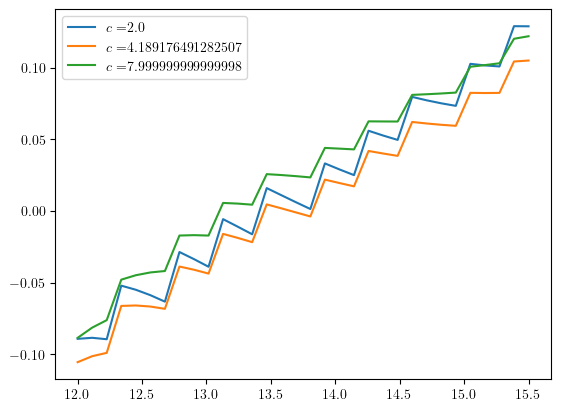

In [78]:
pl.figure()
# for jsim in range(len(theta_ej_array)):
jsim = 0
Y_YSS_sel = save_Y_all[jsim]
fb_fbSS_sel = save_fb_all[jsim]
pl.plot(np.log10(M_array), np.log10(Y_YSS_sel[:,0]), label=r'$c = $' + str(c_array[0]))
# pl.plot(np.log10(M_array), np.log10(Y_YSS_sel[:,1]), label=r'$\theta_{\rm ej} = $' + str(theta_ej_array[jsim]))
pl.plot(np.log10(M_array), np.log10(Y_YSS_sel[:,8]), label=r'$c = $' + str(c_array[8]))
# pl.plot(np.log10(M_array), np.log10(Y_YSS_sel[:,3]), label=r'$\theta_{\rm ej} = $' + str(theta_ej_array[jsim]))
pl.plot(np.log10(M_array), np.log10(Y_YSS_sel[:,15]), label=r'$c = $' + str(c_array[15]))
pl.legend()



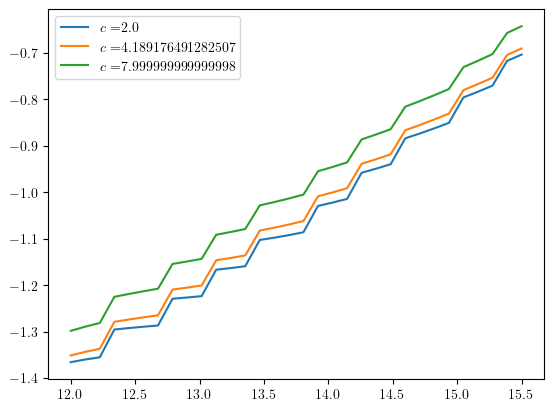

In [79]:
pl.figure()
# for jsim in range(len(theta_ej_array)):
jsim = 4
Y_YSS_sel = save_Y_all[jsim]
fb_fbSS_sel = save_fb_all[jsim]
pl.plot(np.log10(M_array), np.log10(Y_YSS_sel[:,0]), label=r'$c = $' + str(c_array[0]))
# pl.plot(np.log10(M_array), np.log10(Y_YSS_sel[:,1]), label=r'$\theta_{\rm ej} = $' + str(theta_ej_array[jsim]))
pl.plot(np.log10(M_array), np.log10(Y_YSS_sel[:,8]), label=r'$c = $' + str(c_array[8]))
# pl.plot(np.log10(M_array), np.log10(Y_YSS_sel[:,3]), label=r'$\theta_{\rm ej} = $' + str(theta_ej_array[jsim]))
pl.plot(np.log10(M_array), np.log10(Y_YSS_sel[:,15]), label=r'$c = $' + str(c_array[15]))
pl.legend()



In [106]:
import copy
from get_BCMP_profile_jit import BCM_18_wP
from setup_power_spectra_jit import setup_power_BCMP
from tqdm import tqdm
import scipy.integrate as integrate


save_Y_all_0p1 = {}
save_Y_YSS_all_0p1 = {}
save_fb_all_0p1 = {}
theta_ej_array = np.linspace(2.0, 3.0, 5)

for jsim in tqdm(range(len(theta_ej_array))):
    sim_params_dict_vary = copy.deepcopy(sim_params_dict)

    sim_params_dict_vary['theta_ej_0'] = theta_ej_array[jsim]
    sim_params_dict_vary['nu_theta_co_c'] = 0.1
    sim_params_dict_vary['nu_theta_ej_c'] = 0.1    

    halo_params_dict_vary = copy.deepcopy(halo_params_dict)
    halo_params_dict_vary['lg10_Mmin'], halo_params_dict_vary['lg10_Mmax'], halo_params_dict_vary['nM'] = 12.0, 15.5, 32

    BCMP_test = BCM_18_wP(sim_params_dict_vary, halo_params_dict_vary)

    z_test = 0.0   
    z_array = BCMP_test.z_array   
    scale_fac_a_array = 1./(1. + z_array)
    indz = np.argmin(np.abs(z_array - z_test))

    M_array = BCMP_test.M_array
    c_array = BCMP_test.conc_array 
    fb_fbSS_sel = np.zeros((len(M_array), len(c_array)))
    Y_YSS_sel = np.zeros((len(M_array), len(c_array)))
    Y_sel = np.zeros((len(M_array), len(c_array)))    

    for indM in range(len(M_array)):

        for indc in range(len(c_array)):

            r200c_Mz = BCMP_test.r200c_mat[indM, indz]

            log_r_array = np.linspace(np.log(0.05*r200c_Mz), np.log(r200c_Mz), 100)

            # indsel_r = np.where(BCMP_test.r_array < r200c_Mz)[0]
            # r_array_j = BCMP_test.r_array[indsel_r]
            r_array_j = np.exp(log_r_array)

            rho_cga_j = BCMP_test.rho_cga_mat[:,indc, indz, indM]
            rho_clm_j = BCMP_test.rho_clm_mat[:,indc, indz, indM]
            rho_gas_j = BCMP_test.rho_gas_mat[:,indc, indz, indM]
            rho_dmb_j = BCMP_test.rho_dmb_mat[:,indc, indz, indM]
            rho_nfw_j = BCMP_test.rho_nfw_mat[:,indc, indz, indM]
            Pe_mat_j = BCMP_test.Pe_mat_physical[:,indc, indz, indM]

            # interpolate all into log_r_array:
            rho_cga_j = np.interp(log_r_array, np.log(BCMP_test.r_array), rho_cga_j, left=0.0, right=0.0)
            rho_clm_j = np.interp(log_r_array, np.log(BCMP_test.r_array), rho_clm_j, left=0.0, right=0.0)
            rho_gas_j = np.interp(log_r_array, np.log(BCMP_test.r_array), rho_gas_j, left=0.0, right=0.0)
            rho_dmb_j = np.interp(log_r_array, np.log(BCMP_test.r_array), rho_dmb_j, left=0.0, right=0.0)
            rho_nfw_j = np.interp(log_r_array, np.log(BCMP_test.r_array), rho_nfw_j, left=0.0, right=0.0)
            Pe_mat_j = np.interp(log_r_array, np.log(BCMP_test.r_array), Pe_mat_j, left=0.0, right=0.0)

            Mcga_int_j = integrate.simps(4 * np.pi * rho_cga_j * r_array_j**2 * r_array_j, np.log(r_array_j))
            Mclm_int_j = integrate.simps(4 * np.pi * rho_clm_j * r_array_j**2 * r_array_j, np.log(r_array_j))
            Mgas_int_j = integrate.simps(4 * np.pi * rho_gas_j * r_array_j**2 * r_array_j, np.log(r_array_j))
            Mdmb_int_j = integrate.simps(4 * np.pi * rho_dmb_j * r_array_j**2 * r_array_j, np.log(r_array_j))
            Mnfw_int_j = integrate.simps(4 * np.pi * rho_nfw_j * r_array_j**2 * r_array_j, np.log(r_array_j))
            Pe_int_j = integrate.simps(4 * np.pi * Pe_mat_j * r_array_j**2 * r_array_j, np.log(r_array_j)) * (oneMpc_h_to_cm**3)
            Y_int_j = const_coeff * Pe_int_j

            Ez = np.sqrt(bkgrd.growth_factor(BCMP_test.cosmo_jax, scale_fac_a_array))[indz]
            M200_noh = M_array[indM]/h
            h70 = h/0.7
            Y_ss = 97.6 * (1/h70) * (Ez**(2/3.)) * (M200_noh/(1e15/h70))**(5/3.) * (Ob/0.043) * (0.25/Om)
            fb_ss = Ob/Om

            fcga = BCMP_test.fcga_array[indM]
            fstar = BCMP_test.fstar_array[indM]
            fsga = fstar - fcga
            fclm = BCMP_test.fclm_array[indM]

            fgas_ltr200 = Mgas_int_j/Mdmb_int_j
            fsga_ltr200 = (fsga/fclm) * (Mclm_int_j/Mdmb_int_j)
            fcga_ltr200 = Mcga_int_j/Mdmb_int_j

            fb_ltr200 = fgas_ltr200 + fsga_ltr200 + fcga_ltr200
            fb_fbSS_sel[indM, indc] = fb_ltr200/fb_ss
            Y_YSS_sel[indM, indc] = Y_int_j/Y_ss
            Y_sel[indM, indc] = Y_int_j

    save_Y_all_0p1[jsim] = Y_sel    
    save_Y_YSS_all_0p1[jsim] = Y_YSS_sel
    save_fb_all_0p1[jsim] = fb_fbSS_sel







100%|██████████| 5/5 [01:42<00:00, 20.43s/it]


In [107]:
import copy
from get_BCMP_profile_jit import BCM_18_wP
from setup_power_spectra_jit import setup_power_BCMP
from tqdm import tqdm
import scipy.integrate as integrate


save_Y_all_0p2 = {}
save_Y_YSS_all_0p2 = {}
save_fb_all_0p2 = {}
theta_ej_array = np.linspace(2.0, 3.0, 5)

for jsim in tqdm(range(len(theta_ej_array))):
    sim_params_dict_vary = copy.deepcopy(sim_params_dict)

    sim_params_dict_vary['theta_ej_0'] = theta_ej_array[jsim]
    sim_params_dict_vary['nu_theta_co_c'] = 0.2
    sim_params_dict_vary['nu_theta_ej_c'] = 0.2    

    halo_params_dict_vary = copy.deepcopy(halo_params_dict)
    halo_params_dict_vary['lg10_Mmin'], halo_params_dict_vary['lg10_Mmax'], halo_params_dict_vary['nM'] = 12.0, 15.5, 32

    BCMP_test = BCM_18_wP(sim_params_dict_vary, halo_params_dict_vary)

    z_test = 0.0   
    z_array = BCMP_test.z_array   
    scale_fac_a_array = 1./(1. + z_array)
    indz = np.argmin(np.abs(z_array - z_test))

    M_array = BCMP_test.M_array
    c_array = BCMP_test.conc_array 
    fb_fbSS_sel = np.zeros((len(M_array), len(c_array)))
    Y_YSS_sel = np.zeros((len(M_array), len(c_array)))
    Y_sel = np.zeros((len(M_array), len(c_array)))    

    for indM in range(len(M_array)):

        for indc in range(len(c_array)):

            r200c_Mz = BCMP_test.r200c_mat[indM, indz]

            log_r_array = np.linspace(np.log(0.05*r200c_Mz), np.log(r200c_Mz), 100)

            # indsel_r = np.where(BCMP_test.r_array < r200c_Mz)[0]
            # r_array_j = BCMP_test.r_array[indsel_r]
            r_array_j = np.exp(log_r_array)

            rho_cga_j = BCMP_test.rho_cga_mat[:,indc, indz, indM]
            rho_clm_j = BCMP_test.rho_clm_mat[:,indc, indz, indM]
            rho_gas_j = BCMP_test.rho_gas_mat[:,indc, indz, indM]
            rho_dmb_j = BCMP_test.rho_dmb_mat[:,indc, indz, indM]
            rho_nfw_j = BCMP_test.rho_nfw_mat[:,indc, indz, indM]
            Pe_mat_j = BCMP_test.Pe_mat_physical[:,indc, indz, indM]

            # interpolate all into log_r_array:
            rho_cga_j = np.interp(log_r_array, np.log(BCMP_test.r_array), rho_cga_j, left=0.0, right=0.0)
            rho_clm_j = np.interp(log_r_array, np.log(BCMP_test.r_array), rho_clm_j, left=0.0, right=0.0)
            rho_gas_j = np.interp(log_r_array, np.log(BCMP_test.r_array), rho_gas_j, left=0.0, right=0.0)
            rho_dmb_j = np.interp(log_r_array, np.log(BCMP_test.r_array), rho_dmb_j, left=0.0, right=0.0)
            rho_nfw_j = np.interp(log_r_array, np.log(BCMP_test.r_array), rho_nfw_j, left=0.0, right=0.0)
            Pe_mat_j = np.interp(log_r_array, np.log(BCMP_test.r_array), Pe_mat_j, left=0.0, right=0.0)

            Mcga_int_j = integrate.simps(4 * np.pi * rho_cga_j * r_array_j**2 * r_array_j, np.log(r_array_j))
            Mclm_int_j = integrate.simps(4 * np.pi * rho_clm_j * r_array_j**2 * r_array_j, np.log(r_array_j))
            Mgas_int_j = integrate.simps(4 * np.pi * rho_gas_j * r_array_j**2 * r_array_j, np.log(r_array_j))
            Mdmb_int_j = integrate.simps(4 * np.pi * rho_dmb_j * r_array_j**2 * r_array_j, np.log(r_array_j))
            Mnfw_int_j = integrate.simps(4 * np.pi * rho_nfw_j * r_array_j**2 * r_array_j, np.log(r_array_j))
            Pe_int_j = integrate.simps(4 * np.pi * Pe_mat_j * r_array_j**2 * r_array_j, np.log(r_array_j)) * (oneMpc_h_to_cm**3)
            Y_int_j = const_coeff * Pe_int_j

            Ez = np.sqrt(bkgrd.growth_factor(BCMP_test.cosmo_jax, scale_fac_a_array))[indz]
            M200_noh = M_array[indM]/h
            h70 = h/0.7
            Y_ss = 97.6 * (1/h70) * (Ez**(2/3.)) * (M200_noh/(1e15/h70))**(5/3.) * (Ob/0.043) * (0.25/Om)
            fb_ss = Ob/Om

            fcga = BCMP_test.fcga_array[indM]
            fstar = BCMP_test.fstar_array[indM]
            fsga = fstar - fcga
            fclm = BCMP_test.fclm_array[indM]

            fgas_ltr200 = Mgas_int_j/Mdmb_int_j
            fsga_ltr200 = (fsga/fclm) * (Mclm_int_j/Mdmb_int_j)
            fcga_ltr200 = Mcga_int_j/Mdmb_int_j

            fb_ltr200 = fgas_ltr200 + fsga_ltr200 + fcga_ltr200
            fb_fbSS_sel[indM, indc] = fb_ltr200/fb_ss
            Y_YSS_sel[indM, indc] = Y_int_j/Y_ss
            Y_sel[indM, indc] = Y_int_j

    save_Y_all_0p2[jsim] = Y_sel    
    save_Y_YSS_all_0p2[jsim] = Y_YSS_sel
    save_fb_all_0p2[jsim] = fb_fbSS_sel







  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [01:41<00:00, 20.37s/it]


In [108]:
import copy
from get_BCMP_profile_jit import BCM_18_wP
from setup_power_spectra_jit import setup_power_BCMP
from tqdm import tqdm
import scipy.integrate as integrate


save_Y_all_0p3 = {}
save_Y_YSS_all_0p3 = {}
save_fb_all_0p3 = {}
theta_ej_array = np.linspace(2.0, 3.0, 5)

for jsim in tqdm(range(len(theta_ej_array))):
    sim_params_dict_vary = copy.deepcopy(sim_params_dict)

    sim_params_dict_vary['theta_ej_0'] = theta_ej_array[jsim]
    sim_params_dict_vary['nu_theta_co_c'] = 0.3
    sim_params_dict_vary['nu_theta_ej_c'] = 0.3   

    halo_params_dict_vary = copy.deepcopy(halo_params_dict)
    halo_params_dict_vary['lg10_Mmin'], halo_params_dict_vary['lg10_Mmax'], halo_params_dict_vary['nM'] = 12.0, 15.5, 32

    BCMP_test = BCM_18_wP(sim_params_dict_vary, halo_params_dict_vary)

    z_test = 0.0   
    z_array = BCMP_test.z_array   
    scale_fac_a_array = 1./(1. + z_array)
    indz = np.argmin(np.abs(z_array - z_test))

    M_array = BCMP_test.M_array
    c_array = BCMP_test.conc_array 
    fb_fbSS_sel = np.zeros((len(M_array), len(c_array)))
    Y_YSS_sel = np.zeros((len(M_array), len(c_array)))
    Y_sel = np.zeros((len(M_array), len(c_array)))    

    for indM in range(len(M_array)):

        for indc in range(len(c_array)):

            r200c_Mz = BCMP_test.r200c_mat[indM, indz]

            log_r_array = np.linspace(np.log(0.05*r200c_Mz), np.log(r200c_Mz), 100)

            # indsel_r = np.where(BCMP_test.r_array < r200c_Mz)[0]
            # r_array_j = BCMP_test.r_array[indsel_r]
            r_array_j = np.exp(log_r_array)

            rho_cga_j = BCMP_test.rho_cga_mat[:,indc, indz, indM]
            rho_clm_j = BCMP_test.rho_clm_mat[:,indc, indz, indM]
            rho_gas_j = BCMP_test.rho_gas_mat[:,indc, indz, indM]
            rho_dmb_j = BCMP_test.rho_dmb_mat[:,indc, indz, indM]
            rho_nfw_j = BCMP_test.rho_nfw_mat[:,indc, indz, indM]
            Pe_mat_j = BCMP_test.Pe_mat_physical[:,indc, indz, indM]

            # interpolate all into log_r_array:
            rho_cga_j = np.interp(log_r_array, np.log(BCMP_test.r_array), rho_cga_j, left=0.0, right=0.0)
            rho_clm_j = np.interp(log_r_array, np.log(BCMP_test.r_array), rho_clm_j, left=0.0, right=0.0)
            rho_gas_j = np.interp(log_r_array, np.log(BCMP_test.r_array), rho_gas_j, left=0.0, right=0.0)
            rho_dmb_j = np.interp(log_r_array, np.log(BCMP_test.r_array), rho_dmb_j, left=0.0, right=0.0)
            rho_nfw_j = np.interp(log_r_array, np.log(BCMP_test.r_array), rho_nfw_j, left=0.0, right=0.0)
            Pe_mat_j = np.interp(log_r_array, np.log(BCMP_test.r_array), Pe_mat_j, left=0.0, right=0.0)

            Mcga_int_j = integrate.simps(4 * np.pi * rho_cga_j * r_array_j**2 * r_array_j, np.log(r_array_j))
            Mclm_int_j = integrate.simps(4 * np.pi * rho_clm_j * r_array_j**2 * r_array_j, np.log(r_array_j))
            Mgas_int_j = integrate.simps(4 * np.pi * rho_gas_j * r_array_j**2 * r_array_j, np.log(r_array_j))
            Mdmb_int_j = integrate.simps(4 * np.pi * rho_dmb_j * r_array_j**2 * r_array_j, np.log(r_array_j))
            Mnfw_int_j = integrate.simps(4 * np.pi * rho_nfw_j * r_array_j**2 * r_array_j, np.log(r_array_j))
            Pe_int_j = integrate.simps(4 * np.pi * Pe_mat_j * r_array_j**2 * r_array_j, np.log(r_array_j)) * (oneMpc_h_to_cm**3)
            Y_int_j = const_coeff * Pe_int_j

            Ez = np.sqrt(bkgrd.growth_factor(BCMP_test.cosmo_jax, scale_fac_a_array))[indz]
            M200_noh = M_array[indM]/h
            h70 = h/0.7
            Y_ss = 97.6 * (1/h70) * (Ez**(2/3.)) * (M200_noh/(1e15/h70))**(5/3.) * (Ob/0.043) * (0.25/Om)
            fb_ss = Ob/Om

            fcga = BCMP_test.fcga_array[indM]
            fstar = BCMP_test.fstar_array[indM]
            fsga = fstar - fcga
            fclm = BCMP_test.fclm_array[indM]

            fgas_ltr200 = Mgas_int_j/Mdmb_int_j
            fsga_ltr200 = (fsga/fclm) * (Mclm_int_j/Mdmb_int_j)
            fcga_ltr200 = Mcga_int_j/Mdmb_int_j

            fb_ltr200 = fgas_ltr200 + fsga_ltr200 + fcga_ltr200
            fb_fbSS_sel[indM, indc] = fb_ltr200/fb_ss
            Y_YSS_sel[indM, indc] = Y_int_j/Y_ss
            Y_sel[indM, indc] = Y_int_j

    save_Y_all_0p3[jsim] = Y_sel    
    save_Y_YSS_all_0p3[jsim] = Y_YSS_sel
    save_fb_all_0p3[jsim] = fb_fbSS_sel







100%|██████████| 5/5 [01:42<00:00, 20.51s/it]


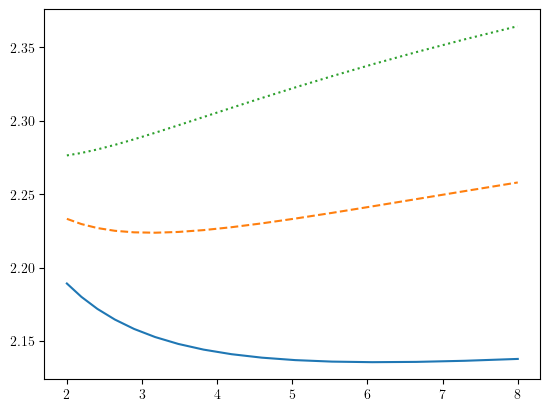

In [113]:
# pl.figure()
# # for jsim in range(len(theta_ej_array)):
# jsim = 1
# Y_YSS_sel = save_Y_all[jsim]
# fb_fbSS_sel = save_fb_all[jsim]
# pl.plot(np.log10(M_array), np.log10(Y_YSS_sel[:,2]), label=r'$c = $' + str(np.round(c_array[2], 2)))
# # pl.plot(np.log10(M_array), np.log10(Y_YSS_sel[:,1]), label=r'$\theta_{\rm ej} = $' + str(theta_ej_array[jsim]))
# pl.plot(np.log10(M_array), np.log10(Y_YSS_sel[:,8]), label=r'$c = $' + str(np.round(c_array[8], 2)))
# # pl.plot(np.log10(M_array), np.log10(Y_YSS_sel[:,3]), label=r'$\theta_{\rm ej} = $' + str(theta_ej_array[jsim]))
# pl.plot(np.log10(M_array), np.log10(Y_YSS_sel[:,15]), label=r'$c = $' + str(np.round(c_array[15], 2)))
# pl.legend()

pl.figure()
# for jsim in range(len(theta_ej_array)):
jsim = 3
Y_YSS_sel = save_Y_all_0p1[jsim]
fb_fbSS_sel = save_fb_all_0p1[jsim]
# indM_13 = np.argmin(np.abs(M_array - 1e13))
# pl.plot((c_array), np.log10(Y_YSS_sel[indM_13,:]), label=r'$c = $' + str(np.round(c_array[2], 2)))
# indM_14 = np.argmin(np.abs(M_array - 1e14))
# pl.plot((c_array), np.log10(Y_YSS_sel[indM_14,:]), label=r'$c = $' + str(np.round(c_array[8], 2)))
indM_15 = np.argmin(np.abs(M_array - 1e15))
pl.plot((c_array), np.log10(Y_YSS_sel[indM_15,:]), label=r'$c = $' + str(np.round(c_array[15], 2)))

# jsim = 1
Y_YSS_sel = save_Y_all_0p2[jsim]
fb_fbSS_sel = save_fb_all_0p2[jsim]
# indM_13 = np.argmin(np.abs(M_array - 1e13))
# pl.plot((c_array), np.log10(Y_YSS_sel[indM_13,:]), ls='--', label=r'$c = $' + str(np.round(c_array[2], 2)))
# indM_14 = np.argmin(np.abs(M_array - 1e14))
# pl.plot((c_array), np.log10(Y_YSS_sel[indM_14,:]), ls='--', label=r'$c = $' + str(np.round(c_array[8], 2)))
indM_15 = np.argmin(np.abs(M_array - 1e15))
pl.plot((c_array), np.log10(Y_YSS_sel[indM_15,:]), ls='--', label=r'$c = $' + str(np.round(c_array[15], 2)))


# jsim = 1
Y_YSS_sel = save_Y_all_0p3[jsim]
fb_fbSS_sel = save_fb_all_0p3[jsim]
# indM_13 = np.argmin(np.abs(M_array - 1e13))
# pl.plot((c_array), np.log10(Y_YSS_sel[indM_13,:]), ls=':', label=r'$c = $' + str(np.round(c_array[2], 2)))
# indM_14 = np.argmin(np.abs(M_array - 1e14))
# pl.plot((c_array), np.log10(Y_YSS_sel[indM_14,:]), ls=':', label=r'$c = $' + str(np.round(c_array[8], 2)))
indM_15 = np.argmin(np.abs(M_array - 1e15))
pl.plot((c_array), np.log10(Y_YSS_sel[indM_15,:]), ls=':', label=r'$c = $' + str(np.round(c_array[15], 2)))



# pl.legend()



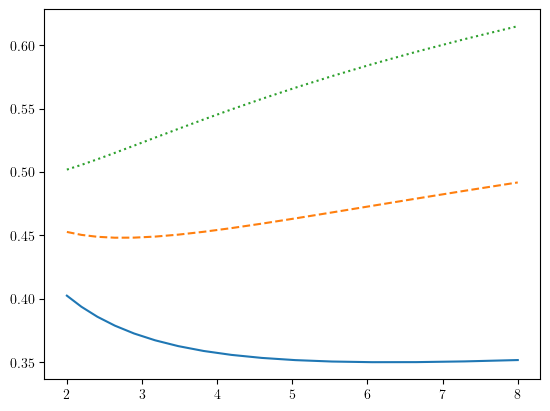

In [114]:
# pl.figure()
# # for jsim in range(len(theta_ej_array)):
# jsim = 1
# Y_YSS_sel = save_Y_all[jsim]
# fb_fbSS_sel = save_fb_all[jsim]
# pl.plot(np.log10(M_array), np.log10(Y_YSS_sel[:,2]), label=r'$c = $' + str(np.round(c_array[2], 2)))
# # pl.plot(np.log10(M_array), np.log10(Y_YSS_sel[:,1]), label=r'$\theta_{\rm ej} = $' + str(theta_ej_array[jsim]))
# pl.plot(np.log10(M_array), np.log10(Y_YSS_sel[:,8]), label=r'$c = $' + str(np.round(c_array[8], 2)))
# # pl.plot(np.log10(M_array), np.log10(Y_YSS_sel[:,3]), label=r'$\theta_{\rm ej} = $' + str(theta_ej_array[jsim]))
# pl.plot(np.log10(M_array), np.log10(Y_YSS_sel[:,15]), label=r'$c = $' + str(np.round(c_array[15], 2)))
# pl.legend()

pl.figure()
# for jsim in range(len(theta_ej_array)):
jsim = 3
Y_YSS_sel = save_Y_all_0p1[jsim]
fb_fbSS_sel = save_fb_all_0p1[jsim]
# indM_13 = np.argmin(np.abs(M_array - 1e13))
# pl.plot((c_array), np.log10(Y_YSS_sel[indM_13,:]), label=r'$c = $' + str(np.round(c_array[2], 2)))
indM_14 = np.argmin(np.abs(M_array - 1e14))
pl.plot((c_array), np.log10(Y_YSS_sel[indM_14,:]), label=r'$c = $' + str(np.round(c_array[8], 2)))
# indM_15 = np.argmin(np.abs(M_array - 1e15))
# pl.plot((c_array), np.log10(Y_YSS_sel[indM_15,:]), label=r'$c = $' + str(np.round(c_array[15], 2)))

# jsim = 1
Y_YSS_sel = save_Y_all_0p2[jsim]
fb_fbSS_sel = save_fb_all_0p2[jsim]
# indM_13 = np.argmin(np.abs(M_array - 1e13))
# pl.plot((c_array), np.log10(Y_YSS_sel[indM_13,:]), ls='--', label=r'$c = $' + str(np.round(c_array[2], 2)))
indM_14 = np.argmin(np.abs(M_array - 1e14))
pl.plot((c_array), np.log10(Y_YSS_sel[indM_14,:]), ls='--', label=r'$c = $' + str(np.round(c_array[8], 2)))
# indM_15 = np.argmin(np.abs(M_array - 1e15))
# pl.plot((c_array), np.log10(Y_YSS_sel[indM_15,:]), ls='--', label=r'$c = $' + str(np.round(c_array[15], 2)))


# jsim = 1
Y_YSS_sel = save_Y_all_0p3[jsim]
fb_fbSS_sel = save_fb_all_0p3[jsim]
# indM_13 = np.argmin(np.abs(M_array - 1e13))
# pl.plot((c_array), np.log10(Y_YSS_sel[indM_13,:]), ls=':', label=r'$c = $' + str(np.round(c_array[2], 2)))
indM_14 = np.argmin(np.abs(M_array - 1e14))
pl.plot((c_array), np.log10(Y_YSS_sel[indM_14,:]), ls=':', label=r'$c = $' + str(np.round(c_array[8], 2)))
# indM_15 = np.argmin(np.abs(M_array - 1e15))
# pl.plot((c_array), np.log10(Y_YSS_sel[indM_15,:]), ls=':', label=r'$c = $' + str(np.round(c_array[15], 2)))



# pl.legend()



In [ ]:
# pl.figure()
# # for jsim in range(len(theta_ej_array)):
# jsim = 1
# Y_YSS_sel = save_Y_all[jsim]
# fb_fbSS_sel = save_fb_all[jsim]
# pl.plot(np.log10(M_array), np.log10(Y_YSS_sel[:,2]), label=r'$c = $' + str(np.round(c_array[2], 2)))
# # pl.plot(np.log10(M_array), np.log10(Y_YSS_sel[:,1]), label=r'$\theta_{\rm ej} = $' + str(theta_ej_array[jsim]))
# pl.plot(np.log10(M_array), np.log10(Y_YSS_sel[:,8]), label=r'$c = $' + str(np.round(c_array[8], 2)))
# # pl.plot(np.log10(M_array), np.log10(Y_YSS_sel[:,3]), label=r'$\theta_{\rm ej} = $' + str(theta_ej_array[jsim]))
# pl.plot(np.log10(M_array), np.log10(Y_YSS_sel[:,15]), label=r'$c = $' + str(np.round(c_array[15], 2)))
# pl.legend()

pl.figure()
# for jsim in range(len(theta_ej_array)):
jsim = 1
Y_YSS_sel = save_Y_all_0p1[jsim]
fb_fbSS_sel = save_fb_all_0p1[jsim]
# indM_13 = np.argmin(np.abs(M_array - 1e13))
# pl.plot((c_array), np.log10(Y_YSS_sel[indM_13,:]), label=r'$c = $' + str(np.round(c_array[2], 2)))
indM_14 = np.argmin(np.abs(M_array - 1e14))
pl.plot((c_array), np.log10(Y_YSS_sel[indM_14,:]), label=r'$c = $' + str(np.round(c_array[8], 2)))
# indM_15 = np.argmin(np.abs(M_array - 1e15))
# pl.plot((c_array), np.log10(Y_YSS_sel[indM_15,:]), label=r'$c = $' + str(np.round(c_array[15], 2)))

jsim = 1
Y_YSS_sel = save_Y_all_0p2[jsim]
fb_fbSS_sel = save_fb_all_0p2[jsim]
# indM_13 = np.argmin(np.abs(M_array - 1e13))
# pl.plot((c_array), np.log10(Y_YSS_sel[indM_13,:]), ls='--', label=r'$c = $' + str(np.round(c_array[2], 2)))
indM_14 = np.argmin(np.abs(M_array - 1e14))
pl.plot((c_array), np.log10(Y_YSS_sel[indM_14,:]), ls='--', label=r'$c = $' + str(np.round(c_array[8], 2)))
# indM_15 = np.argmin(np.abs(M_array - 1e15))
# pl.plot((c_array), np.log10(Y_YSS_sel[indM_15,:]), ls='--', label=r'$c = $' + str(np.round(c_array[15], 2)))


jsim = 1
Y_YSS_sel = save_Y_all_0p3[jsim]
fb_fbSS_sel = save_fb_all_0p3[jsim]
# indM_13 = np.argmin(np.abs(M_array - 1e13))
# pl.plot((c_array), np.log10(Y_YSS_sel[indM_13,:]), ls=':', label=r'$c = $' + str(np.round(c_array[2], 2)))
# indM_14 = np.argmin(np.abs(M_array - 1e14))
# pl.plot((c_array), np.log10(Y_YSS_sel[indM_14,:]), ls=':', label=r'$c = $' + str(np.round(c_array[8], 2)))
indM_15 = np.argmin(np.abs(M_array - 1e15))
pl.plot((c_array), np.log10(Y_YSS_sel[indM_15,:]), ls=':', label=r'$c = $' + str(np.round(c_array[15], 2)))



# pl.legend()



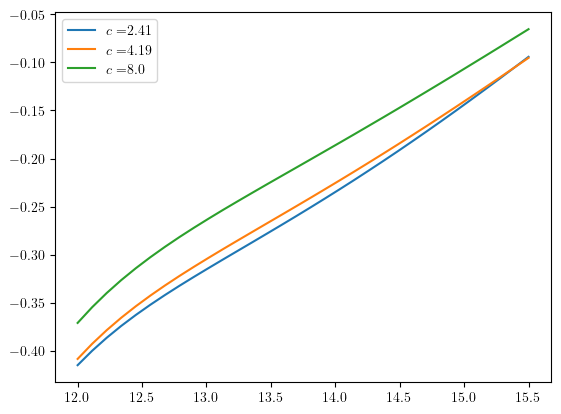

In [104]:
pl.figure()
# for jsim in range(len(theta_ej_array)):
jsim = 4
Y_YSS_sel = save_Y_all[jsim]
fb_fbSS_sel = save_fb_all[jsim]
pl.plot(np.log10(M_array), np.log10(Y_YSS_sel[:,2]), label=r'$c = $' + str(np.round(c_array[2], 2)))
# pl.plot(np.log10(M_array), np.log10(Y_YSS_sel[:,1]), label=r'$\theta_{\rm ej} = $' + str(theta_ej_array[jsim]))
pl.plot(np.log10(M_array), np.log10(Y_YSS_sel[:,8]), label=r'$c = $' + str(np.round(c_array[8], 2)))
# pl.plot(np.log10(M_array), np.log10(Y_YSS_sel[:,3]), label=r'$\theta_{\rm ej} = $' + str(theta_ej_array[jsim]))
pl.plot(np.log10(M_array), np.log10(Y_YSS_sel[:,15]), label=r'$c = $' + str(np.round(c_array[15], 2)))
pl.legend()

